## Homework 10
**Total Points: 5**

**Instructions:**
1. Complete parts 1 through 5, filling in code or responses where marked with `# YOUR CODE HERE` or `# YOUR ANALYSIS HERE`.
2. The libraries you need have already been coded. Do not import additional libraries or move import commands.
3. When finished, run the full notebook by selecting <b>Kernel > Restart & Run All</b>. </li>
4. Submit this completed notebook file to <b>NYU Classes</b>. </li>

In this assignment you will use Dynamic Time Warping (DTW) to compare the similarity of different audio files. The audio folder included with this homework contains:

**audio1a.wav** and **audio1b.wav** - Two versions of the same song (instrumental), both recorded in a professional recording studio.

**audio2a.wav**, **audio2b.wav**, and **audio2c.wav** - Three versions of the same song with vocals, recorded in different conditions.

**Grading:** Each part is worth 1 point.

This assignment uses `dtw-python` which can be installed with the following command:

`pip install dtw-python`

**Important:** Use the `dtw-python` package and *not* the `dtw` package. If you installed `dtw` by mistake, uninstall it and re-install `dtw-python`, as there may be compatibility issues.

In [1]:
import numpy as np
import librosa
import IPython.display as ipd
from scipy.spatial import distance
from dtw import *
import matplotlib.pyplot as plt
import IPython
import IPython.display as ipd

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Part 1: Extract MFCCs

Write a function `extract_mfccs()` which returns MFCCs features as computed by `librosa.features.mfcc`, as well as the audio array. Use the default parameters. The function should also allow you to choose whether or not to return delta MFCCs to account for change over time. Use `librosa.feature.delta` for this.

In [2]:
def extract_mfccs(audio_path, delta=True):
    """Extreact MFCCs (librosa default parameters) from an audio file
    
    Parameters
    ----------
    audio_path : str
        Path to input audio file
    delta : bool
        Whether or not to return delta-MFCCs

    Returns
    -------
    mfccs : np.ndarray, shape=(n, num_mfccs)
        MFCC feature set
    audio : np.array, shape=(num_samples,)
        audio for playback

    """
    mfccs = []
    audio, fs = librosa.load(audio_path)
    
    # Generate an `mfccs` matrix from this one audio file use Librosa.feature.mfcc()
    mfccs = librosa.feature.mfcc(audio, fs) #default 20 mfccs
    # Remove the first MFCC.
    mfccs = mfccs[1:len(mfccs)] 
    mfccs = mfccs.T # 2009 samples by 19 mfccs
    # Delta MFCCs
    if (delta == True):
        mfcc_delta = librosa.feature.delta(mfccs)
        return mfcc_delta, audio
    else:
        return mfccs, audio # audio is 1028276 length

## Part 2: Dynamic Time Warping

Create a function `my_dtw()` which takes two time series (MFCCs) and outputs a DTW matrix. 

1. Follow the algorithm *exactly* as in the slides.
2. Do not use contstraints, even though this will dramatically increase the calculation time.
2. Use `scipy.spatial.distance.euclidean` to calculate the distances.

In [3]:
def my_dtw(query, reference):
    """Compute a DTW matrix
    
    Parameters
    ----------
    query : np.array, shape = (num_features, query_len)
        query timeseries
    reference : np.array, shape = (num_features, reference_len)
        reference timeseries
        
    Returns
    -------
    dtw_matrix : np.ndarray, shape=(query_len, referene_len)
        dtw matrix where each axis is the lengths of query/refernce
        

    """
    
    nx = len(query)
    ny = len(reference)
    table = numpy.zeros((nx, ny)) # dropped a +1
    # Compute left column separately, i.e. j=0.
    table[1:, 0] = numpy.inf
        
    # Compute top row separately, i.e. i=0.
    table[0, 1:] = numpy.inf
    
    # Fill in the rest.
    for i in range(1, nx): # dropped a +1
        for j in range(1, ny): # dropped a +1 here too
            dist = scipy.spatial.distance.euclidean(query[i-1], reference[j-1])
            table[i, j] = dist + min(table[i-1, j], table[i, j-1], table[i-1, j-1])
    return table

## Part 3: Warp Path
    
Create a function `get_warp_path()` where the input is a DTW matrix  and the output is a matrix with the same dimensions as the input, but where each cell is a 0 except for a cell in the warp path, which is a 1. Remember that the warp path the the least cost (smallest number path) between $D[0,0]$ and $D[n,m]$.  Remember that the warp path must follow a path from the beginning to the end; so using `argmin` on an entire column may not work. 

**Hint**: You may get better results if you work your way back from the end of the matrix (end of both timeseries), following the path with the least cost backwards.

In [4]:
def get_warp_path(dtw_matrix):
    """Get the warp path (best relationship between query and reference) from the DTW matrix
    
    Parameters
    ----------
    dtw_matrix : np.ndarray, shape=(query_len, reference_len)
        dtw matrix where each axis is the lengths of query and refernce
        
    Returns
    -------
    warp : np.ndarray, shape=(query_len, reference_len)
        warp path matrix where all elements are 0 except the warp path, which is 1

    """
    i = dtw_matrix.shape[0]-1 # query len # added this -1
    j = dtw_matrix.shape[1]-1 # ref len

    path = [(i, j)]
    while i > 0 or j > 0: # start at end, backtrack to 0,0
        minval = numpy.inf
        if dtw_matrix[i-1, j] < minval:
            minval = dtw_matrix[i-1, j]
            step = (i-1, j)
        if dtw_matrix[i][j-1] < minval:
            minval = dtw_matrix[i, j-1]
            step = (i, j-1)
        if dtw_matrix[i-1][j-1] < minval:
            minval = dtw_matrix[i-1, j-1]
            step = (i-1, j-1)
        path.insert(0, step)
        i, j = step
    return path

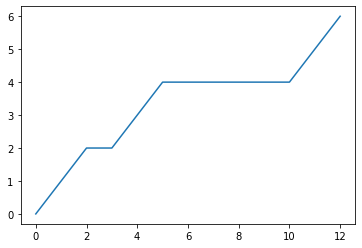

In [5]:
test1 = np.array([1, 0, 1, 0, 1, 0, 1])
test2 = np.array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])

# USE THIS CODE TO TEST DTW WITH THE DTW-PYTHON PACKAGE

#test_dtw = dtw(test1, test2)
#test_dtw.plot()

test_dtw = my_dtw(test1, test2)
warp = get_warp_path(test_dtw)
warp_path = np.array([])
for i in range(len(warp)):
    warp_path = np.append(warp_path, warp[i][0])
plt.plot(warp_path)
#plt.imshow(warp,origin='bottom')

# UNCOMMENT FOR YOUR TEST

#a = my_dtw(test1, test2)
#warp = get_warp_path(a)
#plt.imshow(warp,origin='bottom')

## Part 4: Plot and Sonify
    
Plot the warp path (using either `plot` or `imshow`) from the DTW matrix:

- The Y-axis should show the reference time series
- The X-axis should show the query time series

Then, using the warp path matrix and the code below, create 2 IPython audio objects that begin playing at any given matching point for any two audio files. For example, if frame 100 in time series A is warped to frame 120 in time series B, your two audio players should start at those points. Try this with several different `reference_position` values to see how well the algorithm works. Also remember to convert frames back to samples before passing the audio to `IPython.Audio`.

In [7]:
# USE THIS CODE TO MATCH AN ARBITRARY REFERENCE POSITION TO THE QUERY POSITION

files = ["audio1a","audio1b","audio2a","audio2b","audio2c","audio3a","audio3b"] # I added 3a and 3b
fs = 22050 # hard code
mfccs1, audio1 = extract_mfccs('audio/' + files[3] + '.wav') # query
mfccs2, audio2 = extract_mfccs('audio/' + files[4] + '.wav') # ref

dtw_matrix = my_dtw(mfccs1, mfccs2)
warp = get_warp_path(dtw_matrix)
reference_position = 1000
query_position = warp[reference_position][0]
print("reference_position ", reference_position)
print("query_position ", query_position)

a1 = IPython.display.Audio(audio1[query_position*512: len(audio1)], rate=fs) # "query"
print("Query Audio:")
IPython.display.display(a1, fs) # samples not frames

a2 = IPython.display.Audio(audio2[reference_position*512: len(audio2)], rate=fs) # "ref"
print("Ref Audio:")
IPython.display.display(a2, fs) # samples not frames

reference_position  1000
query_position  757
Query Audio:


22050

Ref Audio:


22050

## Part 5: Analysis

Given that Dynamic Time Warping requires two time series, a reference and a query, develop a method for analyzing the success of the algorithm. How would you quantify results? What additional data (if any) would you need to be able to improve the accuracy of your metrics? If you use existing research, please cite your sources in your analysis.

A few things to consider:

1. Each cell is the cost of the path from $DTW[0,0]$ to that cell. The smaller the number, the closer the match. What cell would be most indicative of an overall similarity score for the entire song?
2. Compare MFCCs to delta-MFCCs and note the differennces, if any.
3. Run DTW on two different songs (not different versions of the same song). What happens?
4. You are provided one song with three versions. Which versions are the closest match? How do you know?
5. Which seems to work better: Audio with vocals or udio without vocals?

Feel free to use your own music (two click tracks of different speeds may be helpful) and create plots as necessary in your analysis.

In [ ]:
"""
Dynamic Time Warping requires a reference and a query and attempts to align them.
I believe the success of this algorithm is measured by how similar the two audio files sound to a listener. In office hours, Dirk and I listened to several clips and discussed which ones sounded more aligned to our ears. 
Therefore, To analyze the success of such an algorithm, I would be interested in surveying listeners. I would survey listeners and ask them which songs sound similar, on a scale of 1-10. Take an average, and compare how well DTW works to that value.
It would be interesting to investigate the length of the DTW path. 

1. The bottom corner cell woudl be most indicative of an overall similarity score for the entire song
2. The DTW works significantly LESS well with the delta-MFCC coefficients than with the original MFCC coefficients. Perhaps there is not much content in the delta-MFCCs if the MFCCs themselves don't change much over time.
3. I added two audio files titled "audio3a" and "audio3b." One is a nice piano groove, the other is Let it Go. Very differnt audio files. The DTW algorithm chose a three-second segment that is somewhat similar. 
I would say the algorithm is doing it's best under the circumstances of being given very differnt material to work on. 
4. For song 2, we are provided with three versions. The two that are most similar are 2a and 2c. Audio2b is different. 
5. Audio with vocals seems to work better. I think it is just more information for the DTW algorithm.